### Data preprocessing has been completed, generating processed_data.csv ###

## feature extraction ##

In [78]:
import nltk as nl
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
import seaborn as sns


Loading BokehJS ...

In [2]:

line_data = pd.read_csv('abcnews-date-text.csv',usecols=["headline_text"]).dropna()
line_data = line_data.drop_duplicates('headline_text')
line_data = line_data.rename(columns={'headline_text': 'headline_text'})

In [83]:

stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def process_stopwords(stop_words):
    processed = set()
    for word in stop_words:
        tokens = tokenizer.tokenize(word.lower())
        processed.update([stemmer.stem(token) for token in tokens])
    return processed

processed_stop_words = process_stopwords(ENGLISH_STOP_WORDS)


punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', "%"]
processed_punc = process_stopwords(punc)

combined_stopwords_list = list(processed_stop_words.union(processed_punc))


def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

tfidf_vectorizer = TfidfVectorizer(stop_words=combined_stopwords_list, tokenizer=tokenize, max_features=1000)  # 保持max_features参数一致
tfidf_data = tfidf_vectorizer.fit_transform(line_data['headline_text'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()

In [84]:

print(f"Number of features: {len(tfidf_features)}")
print(f"Sample features: {tfidf_features[:10]}")


Number of features: 1000
Sample features: ['abbott' 'abc' 'aborigin' 'abus' 'access' 'accid' 'accus' 'act' 'action'
 'ad']


## Traditional Machine Modeling - Unsupervised Learning Clustering ##



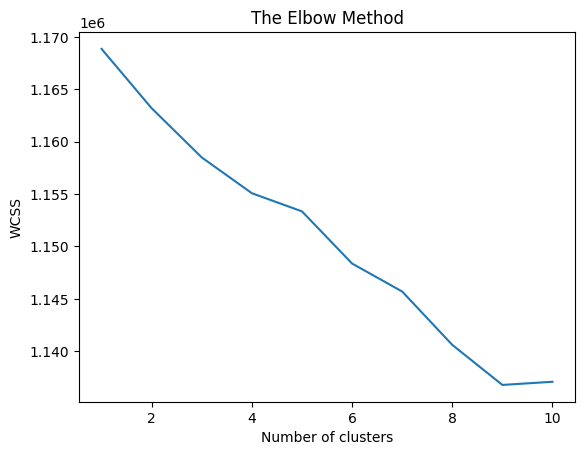

In [5]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(tfidf_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()


In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 9, n_init = 20)
kmeans.fit(tfidf_data)

common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(tfidf_features[word] for word in centroid))

0 : man, charg, jail, polic, court, die, stab, arrest, miss, assault, kill, face, attack, death, car, accus, crash, guilti, child, shoot, sydney, alleg, sex, search, shot
1 : flood, concern, meet, rais, council, plan, resid, air, hit, water, qld, nsw, rain, damag, safeti, farmer, discuss, caus, minist, warn, road, victim, fund, north, river
2 : say, polic, need, minist, expert, govt, trump, mp, plan, australia, union, labor, council, govern, wont, pm, group, opposit, new, chang, public, health, time, wa, lawyer
3 : plan, win, australia, council, australian, court, kill, govt, warn, nsw, charg, fund, open, water, face, sydney, death, year, crash, chang, interview, day, elect, wa, attack
4 : new, zealand, year, law, plan, case, open, record, council, australia, home, set, centr, polic, hospit, announc, deal, south, hope, nsw, coronavirus, appoint, look, wa, covid
5 : murder, charg, man, trial, accus, court, guilti, polic, woman, attempt, jail, case, suspect, face, sentenc, stab, plead, c

### Save Data ###

In [41]:
labels = kmeans.labels_

line_data['Cluster'] = labels
line_data.to_csv('labeled_data.csv', index=True)

### Evaluate Data ###


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

#score = silhouette_score(tfidf_data, labels)
#ch_score = calinski_harabasz_score(tfidf_data, labels)
db_score = davies_bouldin_score(tfidf_data, labels)

#print("Silhouette Score: ", score)
#print("Calinski-Harabasz Score: ", ch_score)
print("Davies-Bouldin Index: ", db_score)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(tfidf_data.toarray())

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar() 
plt.title('t-SNE of KMeans Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1209740 samples in 0.981s...


## Deep Learning - Unsupervised Learning Clustering ##


### Bert model attention ###

In [ ]:
import tokenizers
print(tokenizers.__version__)
from transformers import BertTokenizer

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from sklearn.cluster import KMeans

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_bert_embeddings(sentences):
    model.eval()
    embeddings = []
    batch_size = 32  
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        encoded_input = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**encoded_input)
            batch_embeddings = outputs.last_hidden_state[:, 0].cpu().numpy()
            embeddings.extend(batch_embeddings)
    return np.array(embeddings)

embeddings = get_bert_embeddings(titles)

kmeans = KMeans(n_clusters=5)
kmeans.fit(embeddings)
labels = kmeans.labels_

### Autoencoders ###

In [48]:
from keras.models import Model
from keras.layers import Input, Dense


def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    encoded = Dense(units=int(input_dim / 2), activation='relu')(input_layer)
    encoded = Dense(units=int(input_dim / 4), activation='relu')(encoded)
    
    decoded = Dense(units=int(input_dim / 2), activation='relu')(encoded)
    decoded = Dense(units=input_dim, activation='sigmoid')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    
    encoder = Model(input_layer, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder, encoder

In [ ]:
from keras.callbacks import EarlyStopping

input_dim = tfidf_data.shape[1] 
autoencoder, encoder = build_autoencoder(input_dim)

dense_tfidf_data = tfidf_data.todense()

early_stopping_monitor = EarlyStopping(
    monitor='val_loss', 
    patience=5,         
    verbose=1,            
    restore_best_weights=True  
)

autoencoder.fit(
    dense_tfidf_data, 
    dense_tfidf_data, 
    epochs=50, 
    batch_size=256, 
    validation_split=0.1,
    callbacks=[early_stopping_monitor] 
)

encoded_features = encoder.predict(dense_tfidf_data)
kmeans = KMeans(n_clusters=7)
cluster_labels = kmeans.fit_predict(encoded_features)

print("Cluster labels:", cluster_labels)

# LDA Part #

## Define helper functions


In [10]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [48]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors


In [56]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [38]:
datafile = 'abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)
reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

/tmp/ipykernel_31898/594323990.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)


In [39]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [40]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [41]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  interview cup sydney death world man day north final west
Topic 2:  court govt crash year says port trump claims iraq industry
Topic 3:  health nsw water report nt coast workers pay government action
Topic 4:  australian qld win child public abuse jailed plans assault says
Topic 5:  man police murder guilty missing accused hospital home court farmers
Topic 6:  police says plan car crash rural council killed national fears
Topic 7:  new australia south wa coronavirus council market covid country china


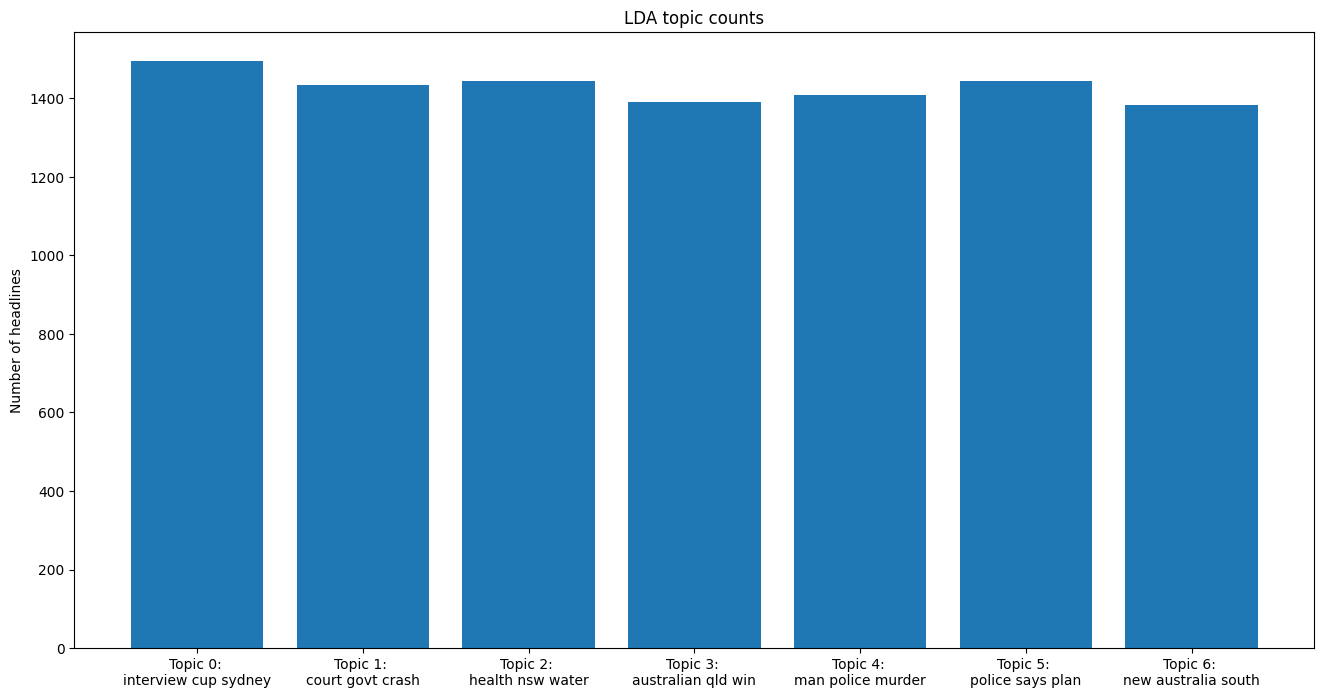

In [42]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [45]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 0.821s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.729340
[t-SNE] KL divergence after 2000 iterations: 1.047030


In [75]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

### Extract and display topics

In [62]:
big_sample_size = 100000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

In [63]:
yearly_data = []
for i in range(2003,2017+1):
    yearly_data.append(reindexed_data['{}'.format(i)].values)

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2017+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

print(yearly_topic_counts)

      Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7
2003     9307     8929     9056    10305     7927     8922     9551
2004    10535    10401    10188    11927    10358     8771    10494
2005    10426    11210     9007    10010    10299    10844    11328
2006     9860     8215    11022     9148    10181     9359     9116
2007    11646    12946     9961    10724    10498    10528    10871
2008    10566    12131    11079    11559    12317    11586    10753
2009    10334    10823    10655    11998    10746    10650    11238
2010    10152    10878    10505    10934    10305    12028    10129
2011    12079    10939    10834    11120    10808    11464    10534
2012    12414    12651    12978    11736    12178    11697    15354
2013    15506    11821    12216    13013    11746    13006    14620
2014     9776    10342    11884    13209    13110    11562    11648
2015    10452    12475    10590    11401     9453    11908    11011
2016     9807     7578     9082     9039     824

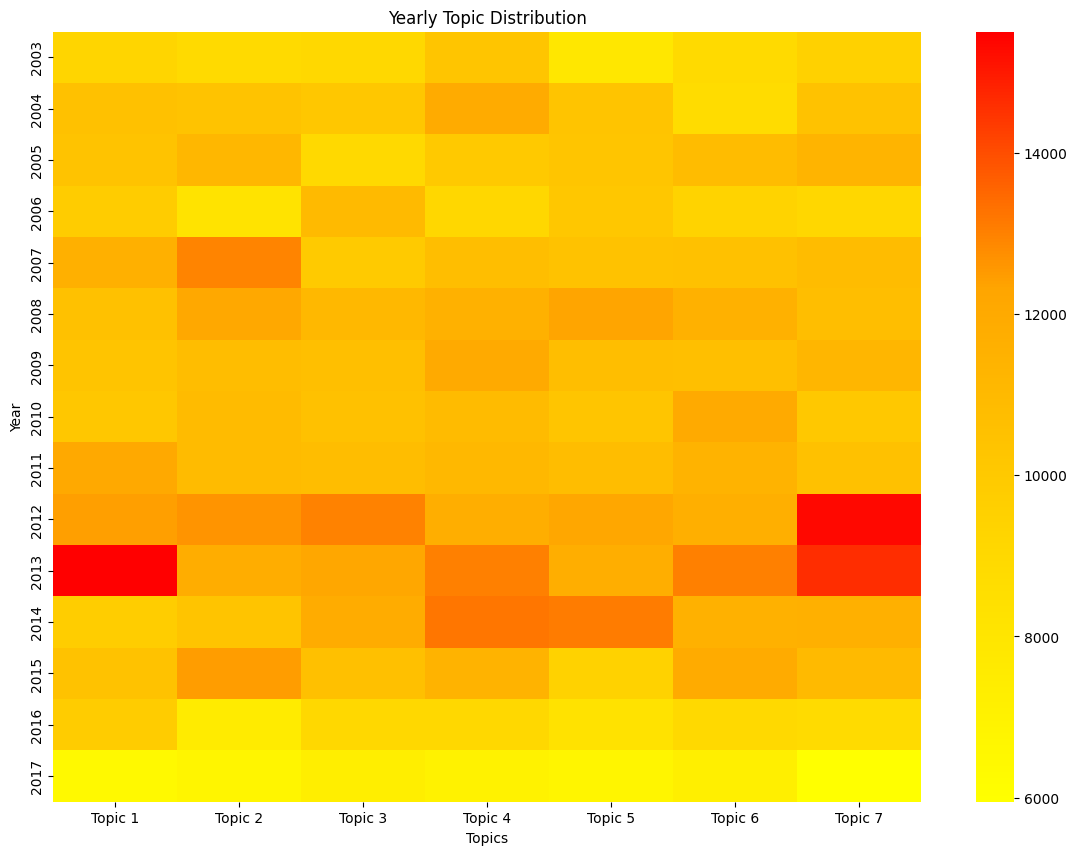

In [79]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["yellow", "gold", "orange", "red"]  
cmap = LinearSegmentedColormap.from_list("custom_yellow", colors, N=256)

fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(yearly_topic_counts, cmap=cmap, ax=ax)
plt.title('Yearly Topic Distribution')
plt.ylabel('Year')
plt.xlabel('Topics')
plt.show()